## Análise de dados da rede Hidro da ANA

Sumário

1. Base de dados da rede Hidro ANA
1. Espacialização da Rede Hidrometereologica Nacional

...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import seaborn as sns
import datetime

### 1. Base de dados da rede Hidro ANA

Dados importados em importHidro.ipynb do inventario do Hidro ANA, segundo o documento "DESCRIÇÃO PARA DISPONIBILIZAR DADOS HIDROMETEOROLÓGICOS DOS SISTEMAS TELEMETRIA 1 E HIDRO" da ANA, disponível em https://www.ana.gov.br/telemetria1ws/Telemetria1ws.pdf

- data de atualização: 29/08/2020

In [2]:
### importa os dados das estações pelo arquivo .csv
dfHidro = pd.read_csv('dfHidro.csv', sep=',', encoding='UTF-8')
dfHidro.head()

Unnamed: 0  BaciaCodigo  SubBaciaCodigo  RioCodigo nmEstado  nmMunicipio  \
0           1            3              32        NaN     PARÁ  SALINÓPOLIS   
1           2            3              32        NaN     PARÁ     MARACANÃ   
2           3            3              32        NaN     PARÁ  SALINÓPOLIS   
3           4            3              32        NaN     PARÁ       CURUÇA   
4           5            3              32        NaN     PARÁ    PRIMAVERA   

  ResponsavelSigla OperadoraSigla  TipoEstacao  Codigo  ...  \
0            INMET          INMET            2   47000  ...   
1            IDESP          IDESP            2   47001  ...   
2              ANA           CPRM            2   47002  ...   
3              ANA           CPRM            2   47003  ...   
4              ANA           CPRM            2   47004  ...   

  TipoRedeEnergetica  TipoRedeNavegacao  TipoRedeCursoDagua  \
0                0.0                0.0                 0.0   
1                0.0                0.0                 9.0   
2                0.0                0.0                 0.0   
3                0.0                0.0                 0.0   
4                0.0                0.0                 0.0   

   TipoRedeEstrategica  TipoRedeCaptacao  TipoRedeSedimentos  \
0                  0.0               1.0                 0.0   
1                  0.0               3.0                 0.0   
2                  0.0               7.0                 0.0   
3                  0.0               7.0                 0.0   
4                  0.0               7.0                 0.0   

   TipoRedeQualAgua  TipoRedeClasseVazao  UltimaAtualizacao  Operando  
0               0.0                  0.0         2019-03-21         0  
1               0.0                  0.0         2005-03-29         1  
2               0.0                  0.0         2018-06-18         1  
3               0.0                  0.0         2018-06-18         1  
4               0.0                  0.0         2018-02-07         1  

[5 rows x 59 columns]

In [5]:
### lista os nomes das colunas para verificação do data frame
dfHidro.columns.values

array(['Unnamed: 0', 'BaciaCodigo', 'SubBaciaCodigo', 'RioCodigo',
       'nmEstado', 'nmMunicipio', 'ResponsavelSigla', 'OperadoraSigla',
       'TipoEstacao', 'Codigo', 'Nome', 'Latitude', 'Longitude',
       'Altitude', 'AreaDrenagem', 'TipoEstacaoEscala',
       'TipoEstacaoRegistradorNivel', 'TipoEstacaoDescLiquida',
       'TipoEstacaoSedimentos', 'TipoEstacaoQualAgua',
       'TipoEstacaoPluviometro', 'TipoEstacaoRegistradorChuva',
       'TipoEstacaoTanqueEvapo', 'TipoEstacaoClimatologica',
       'TipoEstacaoPiezometria', 'TipoEstacaoTelemetrica',
       'PeriodoEscalaInicio', 'PeriodoEscalaFim',
       'PeriodoRegistradorNivelInicio', 'PeriodoRegistradorNivelFim',
       'PeriodoDescLiquidaInicio', 'PeriodoDescLiquidaFim',
       'PeriodoSedimentosInicio', 'PeriodoSedimentosFim',
       'PeriodoQualAguaInicio', 'PeriodoQualAguaFim',
       'PeriodoPluviometroInicio', 'PeriodoPluviometroFim',
       'PeriodoRegistradorChuvaInicio', 'PeriodoRegistradorChuvaFim',
       'Periodo

In [6]:
### função para mapear uma coluna com um dicionário externo em arquivo .csv
def ImportName(DataColumn, Filename, Column):
    df = pd.read_csv(Filename, sep=',', encoding='UTF-8')
    Dict = dict(zip(df['Codigo'], df[Column]))
    DataName = DataColumn.map(Dict)
    return DataName

In [7]:
### insere colunas no data frame com os nomes das [Bacia], [SubBacia] e [Rio] substituindo os códigos
dfHidro['Bacia'] = ImportName(dfHidro['BaciaCodigo'], 'Bacia.csv', 'Nome')
dfHidro['SubBacia'] = ImportName(dfHidro['SubBaciaCodigo'], 'SubBacia.csv', 'Nome')
dfHidro['Rio'] = ImportName(dfHidro['RioCodigo'], 'Rio.csv', 'Nome')
# dfHidro.head()

In [8]:
### insere colunas no data frame com a descrição do [TipoEstacao] substituindo os códigos 1 e 2
dfHidro['TipoEstacao'] = dfHidro['TipoEstacao'].map({1: 'Fluviometrica', 2: 'Pluviometrica'})
dfHidro['TipoEstacao'].value_counts()
# dfHidro.head()

Pluviometrica    21672
Fluviometrica    16535
Name: TipoEstacao, dtype: int64

- Os passos a seguir vao analisar a quantidade de estações que estão em operação (1) e fora de operação (0) e selecionar apenas as que estão em operação, caso queira manter todas as estacoes basta desabilitar o comando.

In [9]:
### número de estações em operação e fora de operação
dfHidro['Operando'].value_counts()

1    24976
0    13231
Name: Operando, dtype: int64

In [10]:
DataInicio = ['PeriodoEscalaInicio', 'PeriodoRegistradorNivelInicio', 'PeriodoDescLiquidaInicio',
              'PeriodoSedimentosInicio', 'PeriodoQualAguaInicio', 'PeriodoPluviometroInicio',
              'PeriodoRegistradorChuvaInicio', 'PeriodoTanqueEvapoInicio',
              'PeriodoClimatologicaInicio', 'PeriodoPiezometriaInicio', 'PeriodoTelemetricaInicio']

DataFim = ['PeriodoEscalaFim', 'PeriodoRegistradorNivelFim', 'PeriodoDescLiquidaFim',
           'PeriodoSedimentosFim', 'PeriodoQualAguaFim', 'PeriodoPluviometroFim',
           'PeriodoRegistradorChuvaFim', 'PeriodoTanqueEvapoFim', 'PeriodoClimatologicaFim',
           'PeriodoPiezometriaFim', 'PeriodoTelemetricaFim']

In [39]:
pd.to_datetime(dfHidro['PeriodoPluviometroInicio'][1]).year

1972

In [10]:
for _date in DataInicio:
    a = getattr(dfHidro.loc[1], _date, None)

In [11]:
dfHidro['DataInicio'] = min(date from )

SyntaxError: invalid syntax (<ipython-input-11-8c9e5e9de9d8>, line 1)

In [12]:
### ao selecionar este comando, passamos a avaliar somente as estações que estão com status operando = 1
### observar que os números de estações no data frame irá reduzir para a quantidade de estações operando = 1
# dfHidroT = dfHidro
dfHidro = dfHidro[dfHidro.Operando == 1]

- Criamos os data frames separados por tipo de estações Pluviométricas e Fluviométricas para facilitar as análises.

In [13]:
### cria os data frames df_RHN_flu e df_RHN_plu
dfHidroFlu = dfHidro[dfHidro['TipoEstacao'] == 'Fluviometrica']
dfHidroPlu = dfHidro[dfHidro['TipoEstacao'] == 'Pluviometrica']

### 2. Espacialização da Rede Hidrometereológica Nacional

2.1. Mapa de densidade hexabin por tipo
* Função para plotar os mapas de distribuição - scatter
* Função para plotar os mapas de densidade hexabin
* Mapas com todas as estações pluviométricas e fluviométricas da rede Hidro
* Mapa de densidade hexabin com todas as estações
* Mapas de densidade hexabin por tipo de estação
* Mapas de densidade hexabin por tipo de rede

In [14]:
### função para plotar o mapa de distribuição - scatter
#       Data:  'Data frame contendo a base de dados',
#       Type:  'Tipo da rede ou tipo da estação (ver as colunas do data frame)',
#       Title: 'Título do Mapa',
#       Color: 'Cor')
### -----
def ScatterMap(Data, Type, Title, Color):
    ### formato do mapa
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())
    ax.set_extent([-100,-20,-60,15], crs = ccrs.PlateCarree())
    ax.set_title(Title)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle = ':')
    gl = ax.gridlines(draw_labels = True, linewidth = 0)
    gl.right_labels = False
    gl.top_labels = False
    ### plot scatter
    if Type == '':
        Data.plot.scatter(ax = ax, x = 'Longitude', y = 'Latitude', s = 0.5, c = Color)
    else:
        Data[Data[Type] == 1].plot.scatter(ax = ax, x = 'Longitude', y = 'Latitude', s = 0.5, c = Color)
    plt.show()

In [15]:
### função para plotar o mapa de densidade hexbin
#       Data:  'Data frame contendo a base de dados',
#       Type:  'Tipo da rede ou tipo da estação (ver as colunas do data frame)',
#       Title: 'Título do Mapa',
#       Color: 'Cores de acordo com a paleta de cores do matplotlib')
### -----
def HexbinDensityMap(Data, Type, Title, Color):
    ### formato do mapa
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree())
    ax.set_extent([-100,-20,-60,15], crs = ccrs.PlateCarree())
    ax.set_title(Title)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle = ':')
    gl = ax.gridlines(draw_labels = True, linewidth = 0)
    gl.right_labels = False
    gl.top_labels = False
    ### plot hexabin
    if Type == '':
        Data.plot.hexbin(ax = ax, x = 'Longitude', y = 'Latitude', reduce_C_function = np.sum, gridsize = 25, cmap = Color)
    else:
        Data[Data[Type] == 1].plot.hexbin(ax = ax, x = 'Longitude', y = 'Latitude', C = Type, reduce_C_function = np.sum, gridsize = 25, cmap = Color)
    plt.show()

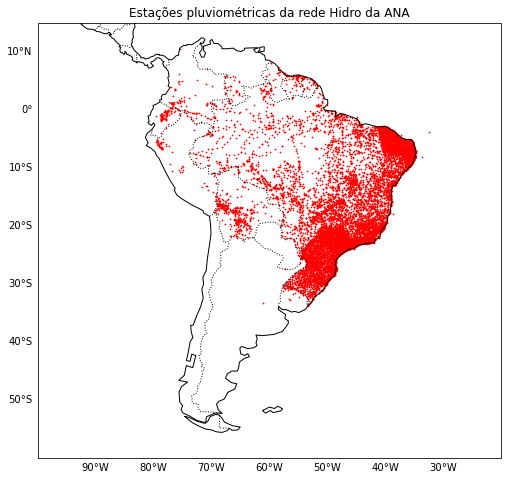

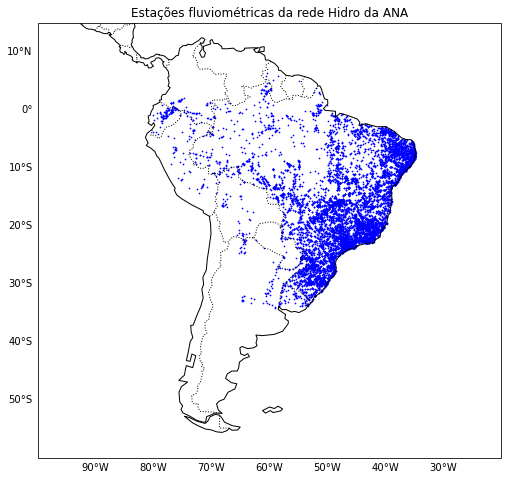

In [16]:
### mapas de densidade hexabin de todas as estações
### função ScatterMap(Data, Type, Title, Color)
ScatterMap(dfHidroPlu, '', 'Estações pluviométricas da rede Hidro da ANA', 'red')
ScatterMap(dfHidroFlu, '', 'Estações fluviométricas da rede Hidro da ANA', 'blue')

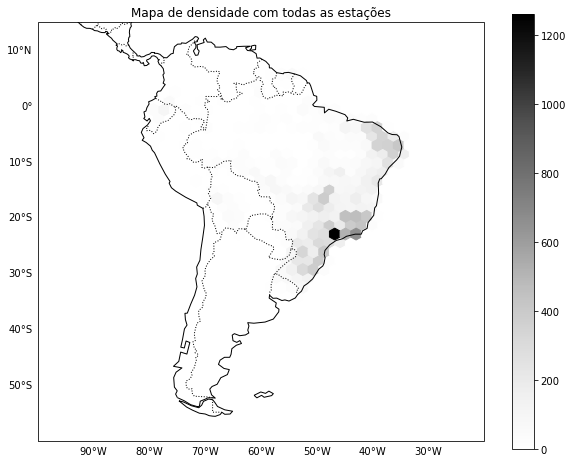

In [17]:
### mapas de densidade hexabin de todas as estações
### função HexbinDensityMap(Data, Type, Title, Color)
HexbinDensityMap(dfHidro, '', 'Mapa de densidade com todas as estações', 'Greys')

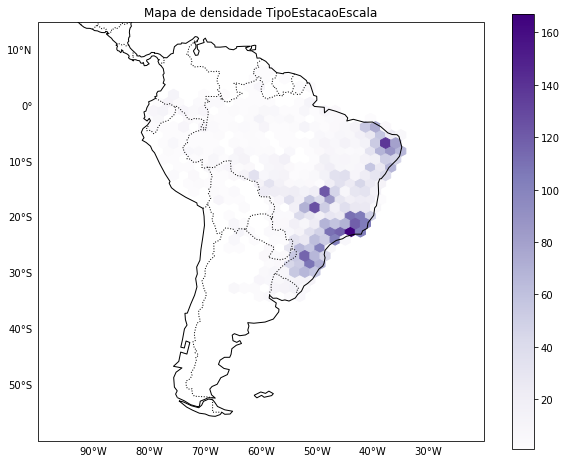

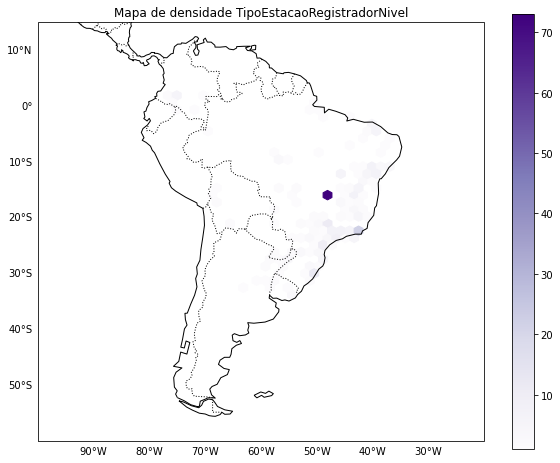

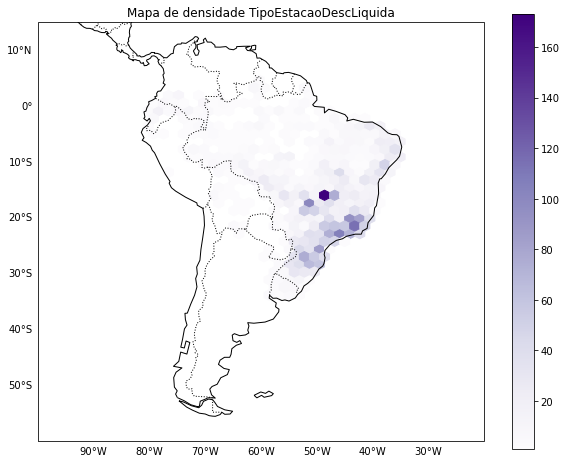

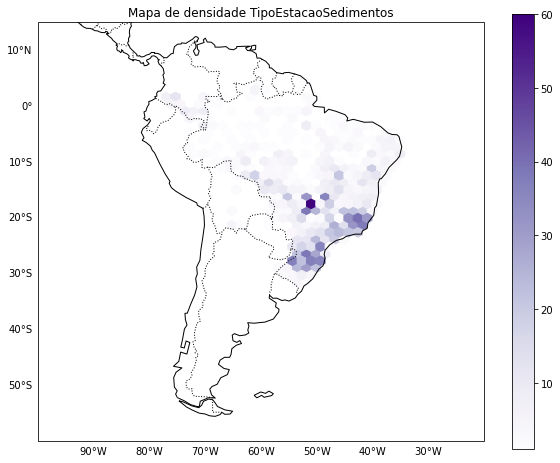

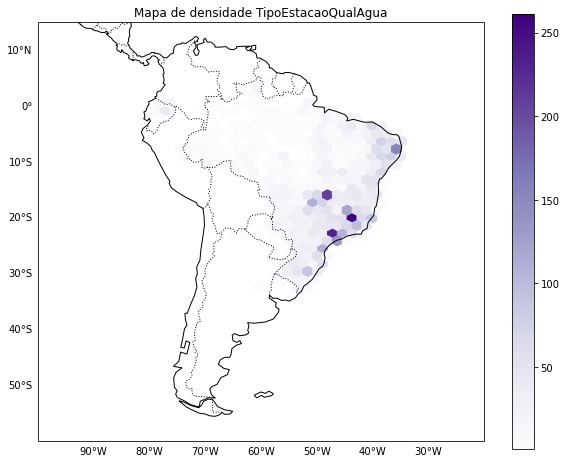

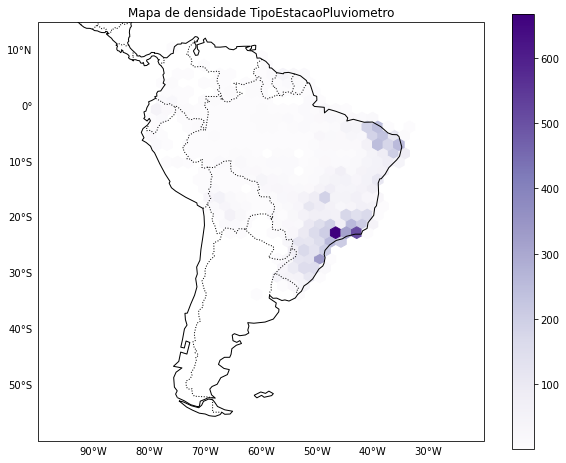

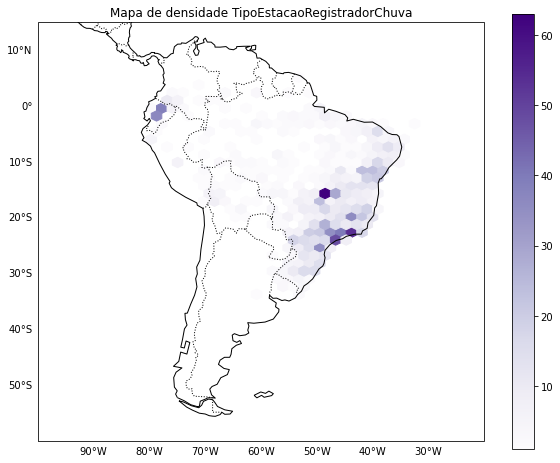

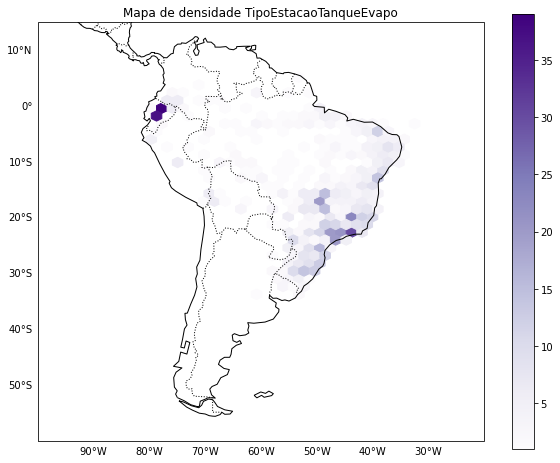

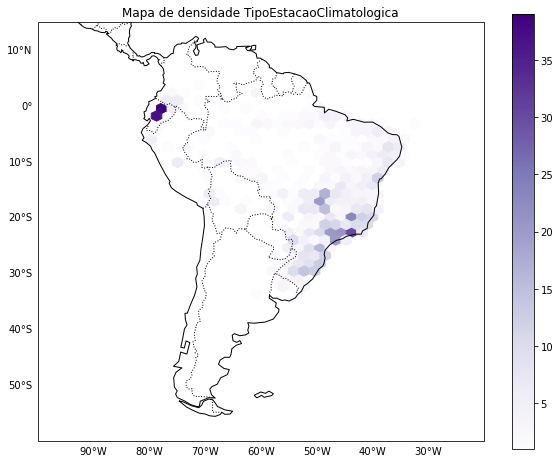

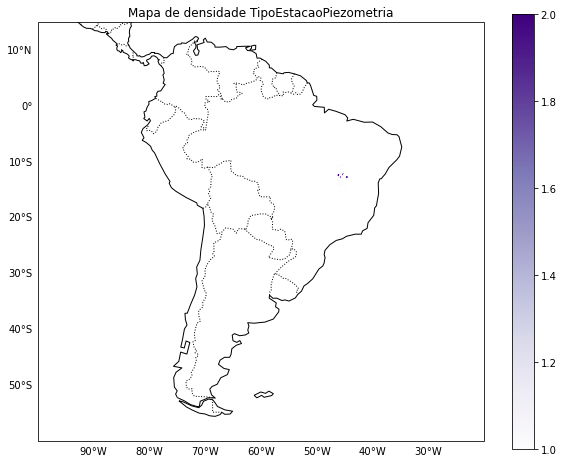

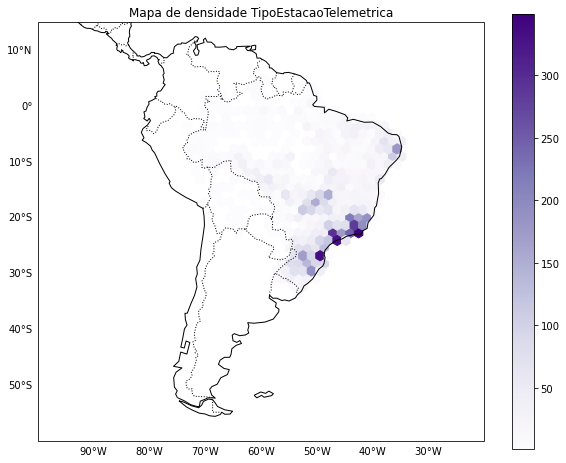

In [18]:
### mapas de densidade hexabin por tipo de estação
TipoEstacao = ['TipoEstacaoEscala', 'TipoEstacaoRegistradorNivel', 'TipoEstacaoDescLiquida',
               'TipoEstacaoSedimentos', 'TipoEstacaoQualAgua', 'TipoEstacaoPluviometro',
               'TipoEstacaoRegistradorChuva', 'TipoEstacaoTanqueEvapo', 'TipoEstacaoClimatologica',
               'TipoEstacaoPiezometria', 'TipoEstacaoTelemetrica']
for aux in TipoEstacao:
    ### função HexbinDensityMap(Data, Type, Title, Color)
    HexbinDensityMap(dfHidro, aux, 'Mapa de densidade {}'.format(aux), 'Purples')

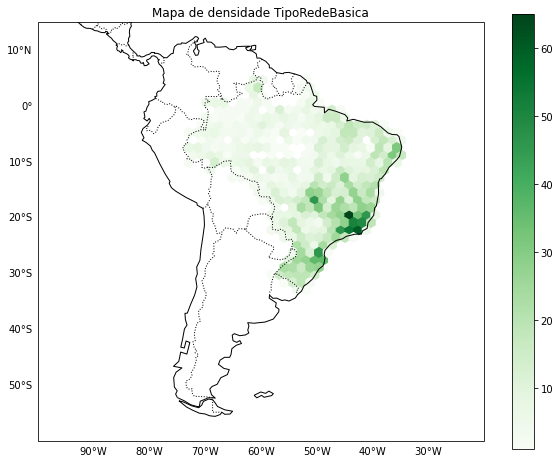

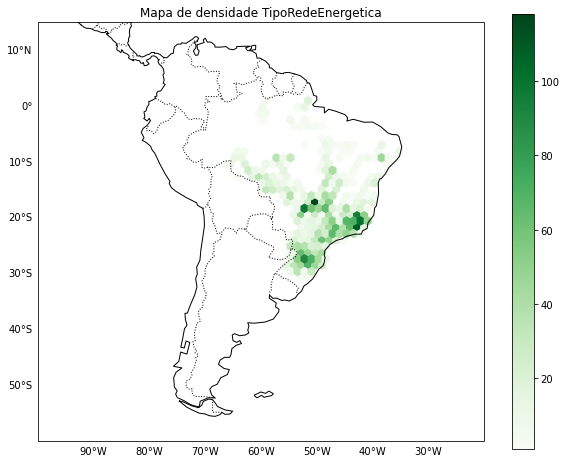

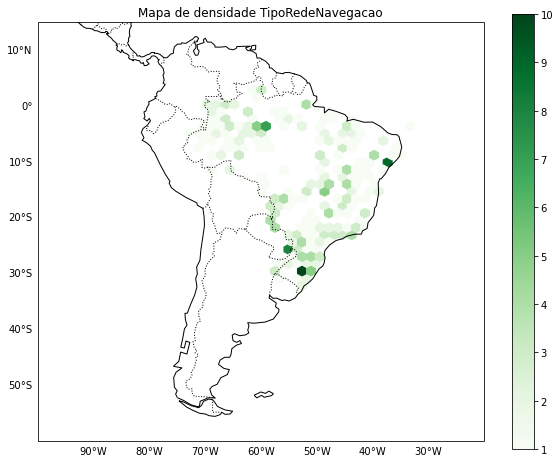

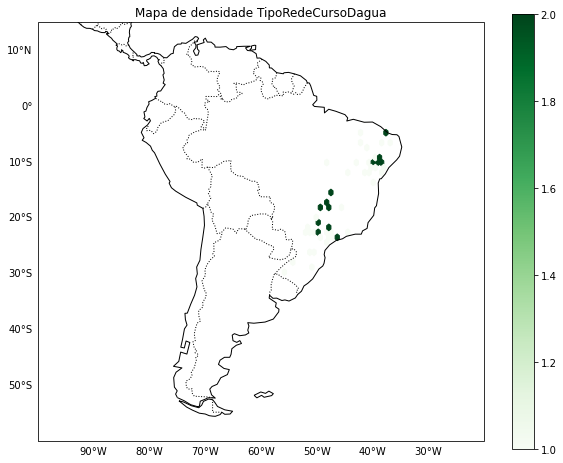

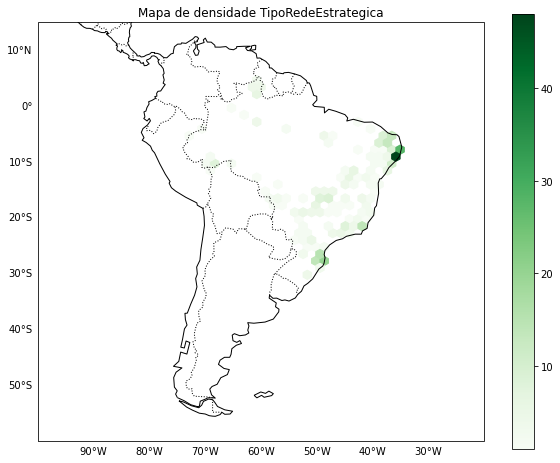

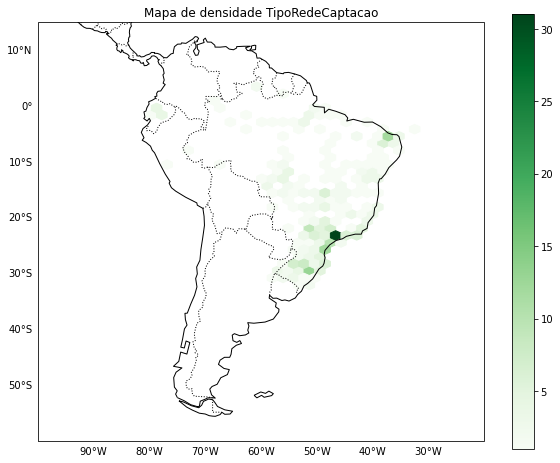

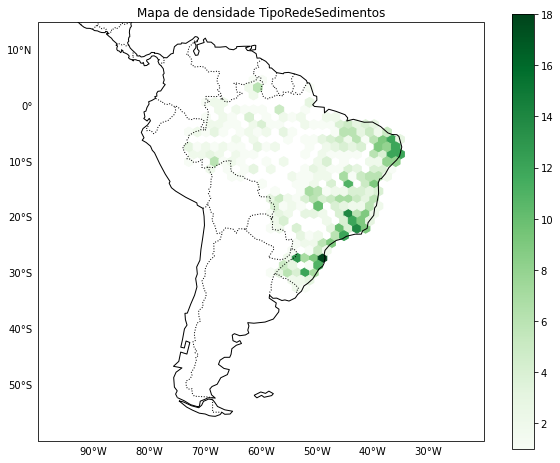

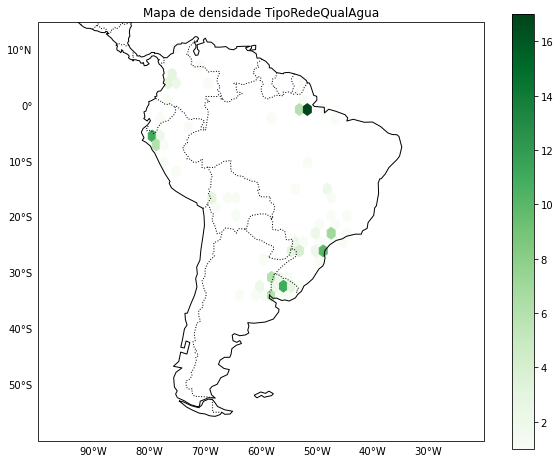

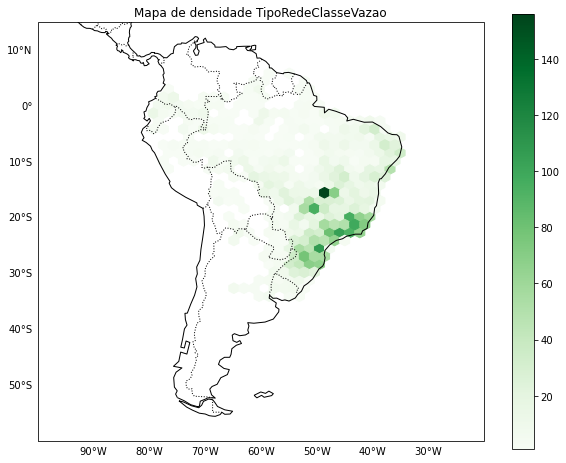

In [19]:
### mapas de densidade hexabin por tipo de rede
TipoRede = ['TipoRedeBasica', 'TipoRedeEnergetica', 'TipoRedeNavegacao',
            'TipoRedeCursoDagua', 'TipoRedeEstrategica', 'TipoRedeCaptacao',
            'TipoRedeSedimentos', 'TipoRedeQualAgua', 'TipoRedeClasseVazao',]
for aux in TipoRede:
    ### função HexbinDensityMap(Data, Type, Title, Color)
    HexbinDensityMap(dfHidro, aux, 'Mapa de densidade {}'.format(aux), 'Greens')

## Operadoras e responsáveis pelas estações

In [20]:
dfHidro['ResponsavelSigla'].value_counts(normalize = True).head(15)

ANA            0.199471
CEMADEN        0.103459
DAEE-SP        0.054292
FUNCEME-CE     0.030790
IGAM-MG        0.030669
INEMA-BA       0.027667
AGUASPARANÁ    0.026185
CETESB-SP      0.023583
DNOCS          0.023022
INMET          0.021220
BOLÍVIA        0.017217
AESA-PB        0.014854
SEMA-RS        0.013173
INEA-RJ        0.012372
SEMAD-GO       0.010410
Name: ResponsavelSigla, dtype: float64

In [21]:
dfHidro['OperadoraSigla'].value_counts(normalize = True).head(15)

CPRM           0.159353
CEMADEN        0.103459
DAEE-SP        0.054452
IGAM-MG        0.036955
AGUASPARANÁ    0.033953
INEMA-BA       0.032551
FUNCEME-CE     0.030870
CETESB-SP      0.023583
DNOCS          0.022902
INMET          0.021220
AESA-PB        0.019499
BOLÍVIA        0.017217
SEMAD-GO       0.010410
SEMA-RS        0.010170
FEPAM-RS       0.009970
Name: OperadoraSigla, dtype: float64